In [1]:
# !pip3 install deepface
# !pip3 install pillow
# !pip3 install mediapipe
# !pip3 install roboflow

In [2]:
DATA_DIR = './_data'

In [3]:
from urllib.request import urlretrieve
import os
import utils
from zipfile import ZipFile

WFACE_DIR = DATA_DIR+'/wider_face'
WFACE_ANNOTATIONS_DIR = WFACE_DIR+'/annotations'
WFACE_IMAGES_DIR = WFACE_DIR+'/images'

os.makedirs(WFACE_DIR, exist_ok = True)

WFACE_VAL_A_PATH = WFACE_ANNOTATIONS_DIR+'/wider_face_split/wider_face_val_bbx_gt.txt'
WFACE_VAL_PATH = WFACE_IMAGES_DIR+'/WIDER_val/images'

wider_face_val_an_url = 'http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip'
file_path = WFACE_DIR+'/wider_face_split.zip'

if not os.path.exists(file_path):
    zip_file, _  = urlretrieve(wider_face_val_an_url, file_path)
    
    zf = ZipFile(zip_file)
    zf.extractall(WFACE_ANNOTATIONS_DIR) 
    zf.close()

wider_face_val_url = 'https://drive.google.com/file/d/1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q/view?usp=sharing'
file_path = WFACE_DIR+'/WIDER_val.zip'
if not os.path.exists(file_path):
    utils.download_file_from_google_drive('1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q', file_path)
    
    zf = ZipFile(file_path)
    zf.extractall(WFACE_IMAGES_DIR) 
    zf.close()

In [4]:
import re
import pandas as pd

wface_an_file = open(WFACE_VAL_A_PATH, "r")

blur_code = ['clear', 'normal blur', 'heavy blur']
expression_code = ['typical', 'exaggerate']
illumination_code = ['normal', 'extreme']
occlusion_code = ['none', 'partial', 'heavy']
pose_code = ['typical', 'atypical']
invalid = ['false', 'true']

#blur, expression, illumination, invalid, occlusion, pose
wface_val_df = pd.DataFrame(columns=[
    'img_path', 'group', 'face',
    'x', 'y', 'w', 'h', 'blur',
    'expression', 'illumination', 
    'invalid', 'occlusion',
    'pose'
])

i = 0
lines = wface_an_file.readlines()
while i < len(lines):
    m = re.search('[^--]+\.jpg$', lines[i])
    if m:
        img_path = lines[i].strip()
        group = img_path.split('/')[0]
    
        i += 1
        n_faces = int(lines[i])
        
        i += 1
        j = 0
        while i < len(lines) and not re.search('[^--]+\.jpg$', lines[i]):
            tokens = re.split('\s+', lines[i])
            tokens = filter(lambda x: len(x) > 0, tokens)
            tokens = [int(t) for t in tokens]
            values = [img_path, group, j]
            values.extend(tokens)
            wface_val_df.loc[len(wface_val_df)] = values
            i += 1
            j += 1
        
        if n_faces != j:
            print(img_path, ": faces({}, {}) didn't match".format(n_faces, j))
    else:
        print(lines[i], "not expected!")
        i += 1
            
wface_an_file.close()
wface_val_df.head()

,img_path,group,face,x,y,w,h,blur,expression,illumination,invalid,occlusion,pose
0,0--Parade/0_Parade_marchingband_1_465.jpg,0--Parade,0,345,211,4,4,2,0,0,0,2,0
1,0--Parade/0_Parade_marchingband_1_465.jpg,0--Parade,1,331,126,3,3,0,0,0,1,0,0
2,0--Parade/0_Parade_marchingband_1_465.jpg,0--Parade,2,250,126,3,4,2,0,0,0,2,0
3,0--Parade/0_Parade_marchingband_1_465.jpg,0--Parade,3,221,128,4,5,0,0,0,1,0,0
4,0--Parade/0_Parade_marchingband_1_465.jpg,0--Parade,4,427,116,3,4,2,0,0,0,2,0


In [76]:
p = '0--Parade/0_Parade_marchingband_1_465.jpg'
wface_val_df[wface_val_df['img_path'] == p]['face'].max()

125

In [87]:
import random

MAX_VARIATIONS = 14
MAX_FACES = 50
visited_images = set()

def randomly_select():
    visited_vars = {
        'blur': set(),
        'expression': set(),
        'illumination': set(),
        'invalid': set(),
        'occlusion': set(),
        'pose': set(),
    }
    
    visited_groups = set()
    n_visited_vars = 0
    
    vars = [
        'blur', 'expression', 'illumination', 
        'invalid', 'occlusion', 'pose'
    ]
    def check_var(d, var):
        return d[var] not in visited_vars[var]

    def add_var(d, var):
        if check_var(d, var):
            visited_vars[var].add(d[var])
            return 1
        return 0
    
    var_images = []
    #blur, expression, illumination, invalid, occlusion, pose
    while n_visited_vars < MAX_VARIATIONS:
        i = random.randint(0, len(wface_val_df)-1)
        d = wface_val_df.iloc[i]
        
        if d['img_path'] in visited_images:
            continue
        
        if d['group'] in visited_groups:
            continue
        
        n_faces = wface_val_df[wface_val_df['img_path'] == d['img_path']]['face'].max()
        if n_faces >= MAX_FACES:
            continue
        
        checks = [check_var(d, var) for var in vars]
        if True in checks:
            var_images.append(WFACE_VAL_PATH+'/'+d['img_path'])
            visited_images.add(d['img_path'])
            visited_groups.add(d['group'])
            for var in vars:
                n_visited_vars += add_var(d, var)
    return var_images

varied_images = randomly_select()

MAX_ITERATIONS = 300//7
min_num_images = 300
i = 0
while len(visited_images) < min_num_images and i < MAX_ITERATIONS:
    randomly_select()
    i += 1

len(visited_images)

305

In [74]:
import os
import re
import shutil
import roboflow

from PIL import Image

ROBOFLOW_ROOT_DIR = './.data/robo/fer-wider-face'
ROBOFLOW_IMAGES_DIR = ROBOFLOW_ROOT_DIR + '/valid/images'
ROBOFLOW_LABELS_DIR = ROBOFLOW_ROOT_DIR + '/valid/labels'
ROBOFLOW_YAML_FILE = ROBOFLOW_ROOT_DIR + '/data.yaml'

os.makedirs(ROBOFLOW_ROOT_DIR, exist_ok=True)
os.makedirs(ROBOFLOW_IMAGES_DIR, exist_ok=True)
os.makedirs(ROBOFLOW_LABELS_DIR, exist_ok=True)

def get_image_shape(img_path):
    img = Image.open(img_path, "r")
    return (img.width, img.height)

def convert_yolov8(x, y, w, h, img_width, img_height):
    
    x_min, x_max = x, x+w
    y_min, y_max = y, y+h
    
    x_center = (x_min + x_max) / 2 / img_width
    y_center = (y_min + y_max) / 2 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
  
    return (x_center, y_center, width, height)

def prepare_robo_project(images, ann_df):
    for img in images:
        src_img_path =  WFACE_VAL_PATH+'/'+img
        img_name = re.search('[^/]+\.jpg$', img).group()
        img_path = ROBOFLOW_IMAGES_DIR + '/' + img_name
        ann_path = ROBOFLOW_LABELS_DIR + '/' + img_name.split('.')[0] + '.txt'
        bboxs = ann_df.loc[ann_df.img_path == img].reset_index()
        
        
        (w, h) = get_image_shape(src_img_path)
        ann_lines = []
        for i in range(0, len(bboxs)):
            ybbox = convert_yolov8(
                bboxs.iloc[i]['x'],
                bboxs.iloc[i]['y'],
                bboxs.iloc[i]['w'],
                bboxs.iloc[i]['h'],
                w, h)
            ann_lines.append('0 {} {} {} {}\n'.format(*ybbox))
        
        shutil.copy(src_img_path, img_path)
        
        ann_f = open(ann_path, "w")
        ann_f.writelines(ann_lines)
        ann_f.close()

        
    yaml_f = open(ROBOFLOW_YAML_FILE, "w")
    yaml_f.write("val: ../valid/images\nnc: 1\nnames: ['neutral']")
    yaml_f.close()

def create_robo_project(rf, project_name):
    ws = rf.workspace('nitesh-c-eszzc')
    if project_name not in [x['name'] for x in ws.project_list if x['name'] == project_name]:
        return ws.create_project(
            project_name=project_name,
            project_type="object-detection",
            project_license="CC BY 4.0",
            annotation="facial-expressions"
        ).id
    else:
       return [x for x in ws.project_list if x['name'] == project_name][0]['id']
    
def upload_robo_project(project_id, root_path):
    project = rf.project(project_id)
    
    for img_name in os.listdir(root_path+'/valid/images'):
        img_path = root_path+'/valid/images/'+img_name
        ann_path = root_path+'/valid/labels/'+img_name.replace('.jpg', '.txt')
        
        project.upload(
            image_path=img_path,
            annotation_path=ann_path,
            split='valid'
        )
        
roboflow.login()

rf = roboflow.Roboflow()
prepare_robo_project(visited_images, wface_val_df)
proj_id = create_robo_project(rf, 'test')
upload_robo_project(proj_id, ROBOFLOW_ROOT_DIR)


In [33]:
# varied_images = [
#     WFACE_VAL_PATH+'/11--Meeting/11_Meeting_Meeting_11_Meeting_Meeting_11_507.jpg',
#     WFACE_VAL_PATH+'/2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_120.jpg',
#     WFACE_VAL_PATH+'/14--Traffic/14_Traffic_Traffic_14_170.jpg',
#     WFACE_VAL_PATH+'/28--Sports_Fan/28_Sports_Fan_Sports_Fan_28_590.jpg',
#     WFACE_VAL_PATH+'/3--Riot/3_Riot_Riot_3_710.jpg',
#     WFACE_VAL_PATH+'/51--Dresses/51_Dresses_wearingdress_51_741.jpg',
#     WFACE_VAL_PATH+'/12--Group/12_Group_Group_12_Group_Group_12_935.jpg',
#     WFACE_VAL_PATH+'/39--Ice_Skating/39_Ice_Skating_iceskiing_39_349.jpg',
#     WFACE_VAL_PATH+'/37--Soccer/37_Soccer_soccer_ball_37_512.jpg'
#  ]

<Figure size 2000x2000 with 0 Axes>

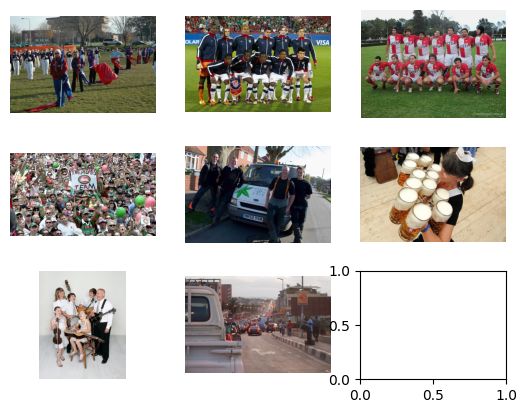

In [44]:
from PIL import Image
from matplotlib import pyplot as plt


VARIED_FACES_DIR = './.data/varied-images'
img_paths = varied_images

imgs = [Image.open(img_path, "r") for img_path in img_paths]
n_imgs = len(imgs)

plt.figure(figsize=(20, 20))

cols = 3
rows = n_imgs//cols
rows += 0 if n_imgs%cols == 0 else 1
f, axarr = plt.subplots(rows,cols) 
for i, img in enumerate(imgs):
  axarr[i//cols][i%cols].imshow(img)
  axarr[i//cols][i%cols].axis('off')

plt.show(block=True)

In [71]:
from deepface import DeepFace

backends = [
  'opencv', 
  'ssd', 
  'dlib', 
  'mtcnn', 
  'retinaface', 
  'mediapipe',
  'yolov8',
  'yunet',
  'fastmtcnn',
]

imgs_faces = []
for img_path in img_paths:
  face_objs = DeepFace.extract_faces(img_path = img_path, 
          target_size = (224, 224), 
          detector_backend = 'retinaface',
          enforce_detection=False
  )
  imgs_faces.append(face_objs)

In [ ]:
from PIL import Image
from PIL import ImageDraw

def annotate_image(img: Image, facial_areas, color='red'):
    dimg = ImageDraw.Draw(img)
    for i, box in enumerate(facial_areas):
        dimg.rectangle(
            (box['x'], box['y'], box['x']+box['w'], box['y']+box['h']), 
            outline=color, width=3)

def annotate_images(imgs, imgs_faces):
  for i, img in enumerate(imgs):
    # face_obj: ['facial_area'], face_objs[0]['confidence'])
    facial_areas = [f['facial_area'] for f in imgs_faces[i]]
    annotate_image(img, facial_areas)


annotate_images(imgs, imgs_faces)


for i, img in enumerate(imgs):
  plt.imshow(img)
  plt.axis('off')
  plt.show(block=True)

In [101]:
from deepface import DeepFace

imgs_emos = []
for img_path in img_paths:
  emo_objs = DeepFace.analyze(
    img_path = img_path,
    detector_backend = 'retinaface',
    enforce_detection=False,
    actions = ['emotion'], align=True, silent=True
  )
  imgs_emos.append(emo_objs)

Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


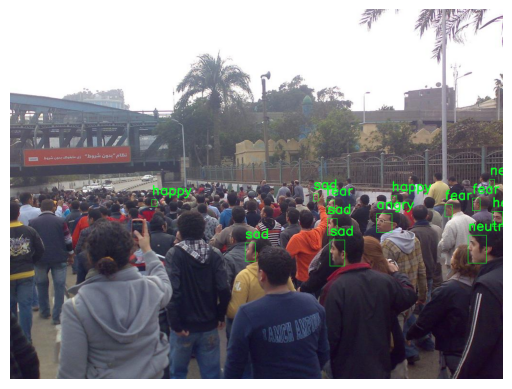

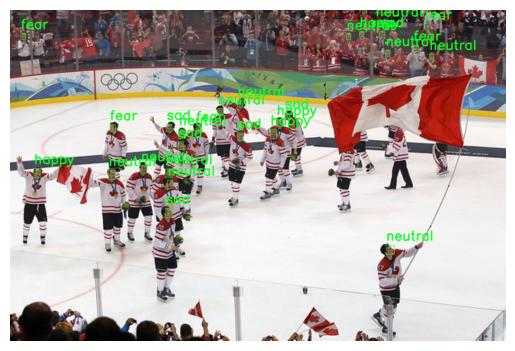

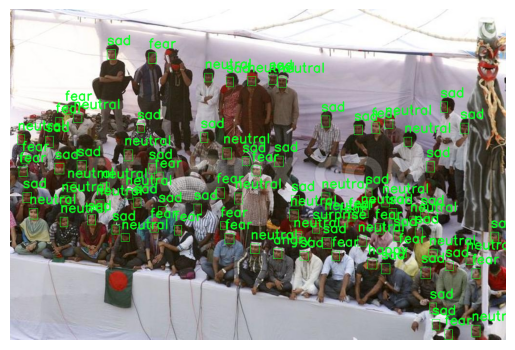

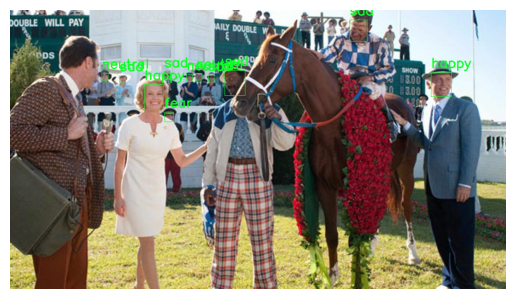

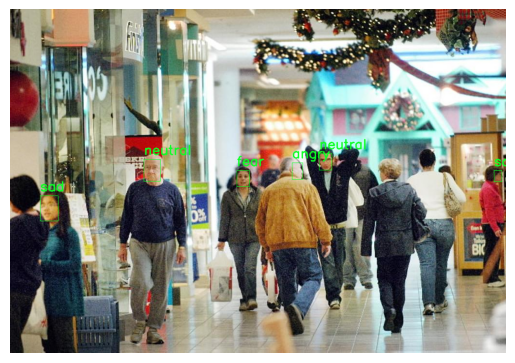

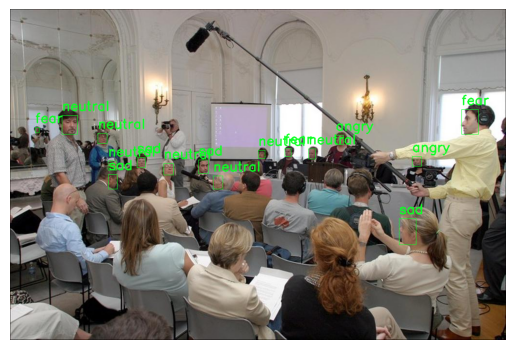

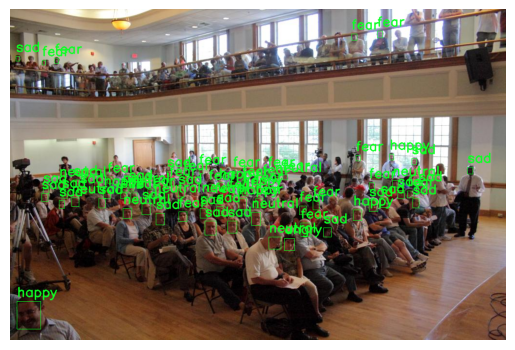

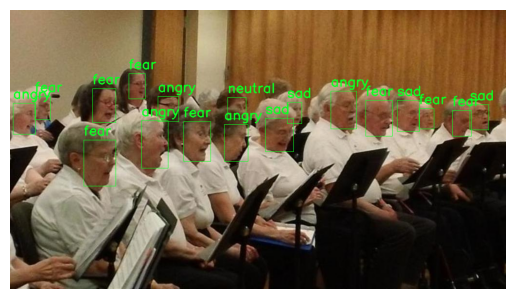

In [102]:
import numpy as np 
import cv2

def annotate_image(img, fareas, labels):
  for i, box in enumerate(fareas):
    img = cv2.rectangle(
      img,
      (box['x'], box['y']),
      (box['x']+box['w'], box['y']+box['h']),
      color=(36,255,12),
      thickness=1
    )
    if labels and labels[i]:
      img = cv2.putText(
        img,
        labels[i],
        (box['x'], box['y']-10),
        cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.9,
        color=(36,255,12),
        thickness=2
      )
  return img

cv_imgs = []
for img_path in img_paths:
  cv_imgs.append(cv2.imread(img_path, cv2.IMREAD_ANYCOLOR))

an_cv_imgs = []
for i, img_emo in enumerate(imgs_emos):
    fareas = [obj['region'] for obj in img_emo]
    emos = [emo['dominant_emotion'] for emo in img_emo]
    an_cv_imgs.append(annotate_image(cv_imgs[i], fareas, labels=emos))

for i, img in enumerate(an_cv_imgs):
  rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(rgb, cmap = plt.cm.Spectral)
  plt.axis('off')
  plt.show(block=True)

In [89]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

def evaluate(ref, pred):
    score = sentence_bleu([ref], pred, weights=[1])
    print(ref, '<>', pred, '<>', score)
    return score

evaluate('angry', 'angry')
evaluate('angry', 'sad')
evaluate('angry', 'sad sad')
evaluate('angry', 'sad sad sad')
evaluate('angry angry', 'sad')
evaluate('angry angry', 'angry')
evaluate('angry angry', 'angry sad')
evaluate('angry', '')
evaluate('', 'sad')

print("----------------------------")

def evaluate_corpus(refs, preds):
    score = corpus_bleu([[r] for r in refs], preds, weights=[1])
    print(score)
    return score

total_score = 0
total_score += evaluate('angry', 'angry')
total_score += evaluate('angry', 'sad')
total_score += evaluate('angry angry', 'angry sad')

corpus_score = evaluate_corpus(['angry', 'angry', 'angry, angry'], ['angry', 'sad', 'angry sad'])

print(corpus_score, ' <> ', total_score/3)

# https://cloud.google.com/translate/automl/docs/evaluate#bleu
#   

angry <> angry <> 1.0
angry <> sad <> 0.17113903967753066
angry <> sad sad <> 0.14285714285714285
angry <> sad sad sad <> 0.0909090909090909
angry angry <> sad <> 0.023161150407600514
angry angry <> angry <> 0.301194211912202
angry angry <> angry sad <> 0.622795757824184
angry <>  <> 0
 <> sad <> 0
----------------------------
angry <> angry <> 1.0
angry <> sad <> 0.17113903967753066
angry angry <> angry sad <> 0.622795757824184
0.569850271833838
0.569850271833838  <>  0.5979782658339049


In [2]:
ROBOFLOW_PROJ_ID = 'nitesh-c-eszzc/fed_wider_face_mini'
ROBOFLOW_PROJ_VER = 1
ROBOFLOW_ROOT_DIR = './.data/robo'
ROBOFLOW_PROJ_DIR = ROBOFLOW_ROOT_DIR + '/' + ROBOFLOW_PROJ_ID + '/' + str(ROBOFLOW_PROJ_VER)

In [3]:
import roboflow
from roboflow import Roboflow

roboflow.login()

Roboflow().project(
    ROBOFLOW_PROJ_ID).version(
        ROBOFLOW_PROJ_VER).download(
            'yolov8', ROBOFLOW_PROJ_DIR, overwrite=True)

You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).
Dependency ultralytics==8.0.134 is required but found version=8.0.178, to fix: `pip install ultralytics==8.0.134`



Extracting Dataset Version Zip to ./.data/robo/nitesh-c-eszzc/fed_wider_face_mini/1 in yolov8:: 100%|██████████| 616/616 [00:04<00:00, 128.86it/s]


In [6]:
from imagewrapper import CVImageWrapper

import math
import os
import yaml
from pathlib import Path
import numpy as np


def read_lines(file_path):
    f = open(file_path, 'r')
    lines = [l.strip() for l in f.readlines()]
    f.close()
    return lines
    
def read_ann(file_path):
    lines = read_lines(file_path)

    annotations = []
    for line in lines:
        annotation = []
        tokens = line.split(' ')
        if len(tokens) == 5:
            annotation = (
                int(tokens[0]),
                np.array([
                    float(tokens[1]),
                    float(tokens[2]),
                    float(tokens[3]),
                    float(tokens[4])
                ])
            )
        annotations.append(annotation)
    return annotations

def concat_labels(lables):
    return ' '.join(sorted(lables))

ROBOFLOW_IMAGES_DIR = ROBOFLOW_PROJ_DIR + '/valid/images'
ROBOFLOW_ANN_DIR = ROBOFLOW_PROJ_DIR + '/valid/labels'
label_names = yaml.safe_load(Path(ROBOFLOW_PROJ_DIR+'/data.yaml').read_text())['names']

img_paths = []
img_anns = {}

for img_name in os.listdir(ROBOFLOW_IMAGES_DIR):
    img_path = ROBOFLOW_IMAGES_DIR+'/'+img_name
    ann_path = ROBOFLOW_ANN_DIR+'/'+img_name.replace('.jpg', '.txt')
    
    img_paths.append(img_path)
    
    img = CVImageWrapper(img_path)
    
    denorm_anns = []
    annotations = read_ann(ann_path)
    img_anns[img_path] = annotations

print('data length (imgs, anns) -> ', len(img_paths), len(img_anns))

data length (imgs, anns) ->  305 305


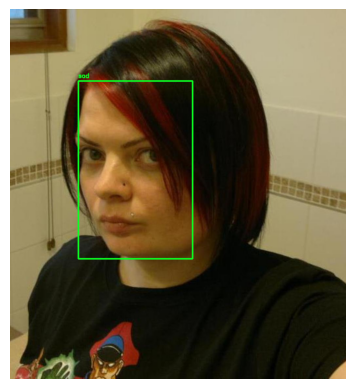

In [7]:
import random
from imagewrapper import CVImageWrapper
from matplotlib import pyplot as plt


i = random.randint(0, len(img_paths)-1)

img_name = img_paths[i]
img_name = ROBOFLOW_IMAGES_DIR+'/13_Interview_Interview_On_Location_13_736_jpg.rf.30284bcf36f8f38a7ccb306a62a392dd.jpg'
img, bboxes, exps = (
    CVImageWrapper(img_name), 
    [ann[1] for ann in img_anns[img_name]], 
    [label_names[ann[0]] for ann in img_anns[img_name]]
)
bboxes = img.denormalize_bboxes(np.array(bboxes))
labels = exps

img.annotate(
    boxes = bboxes,
    labels=labels
)
img.imshow(plt)


# o_img_path = './.data/wider_face/images/WIDER_val/images/13--Interview/13_Interview_Interview_On_Location_13_736.jpg'
# o_df = wface_val_df[wface_val_df.img_path == '13--Interview/13_Interview_Interview_On_Location_13_736.jpg']
# o_bboxes = o_df[['x', 'y', 'w', 'h']].to_numpy()
# o_img = CVImageWrapper(o_img_path)
# o_img.annotate(o_bboxes, labels)
# o_img.imshow(plt)

#209 220 348 542 0 0 0 0 0 0 
